# Libraries

In [1]:
import time
import datetime
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
from IPython.display import HTML
from sklearn.mixture import GaussianMixture
import os
from matplotlib import cm


# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print('Device name:',device)

Device name: cpu


In [2]:
# set figure configuration
plt.rcParams.update({'font.size': 20, 'font.family': 'Arial'})
plt.figure()
plt.show()
plt.close('all')

<Figure size 432x288 with 0 Axes>

# Data preparation

In [3]:
# Define default data type for tensors
dtype = torch.float32  # Change to torch.double if float64 precision is preferred

# Load experimental data from a CSV file
# Specify the full file path where 'All_Data_frames.csv' is located
data = pd.read_csv('../All_Data_frames.csv')
print(data.tail())  # Display the last few rows of the dataset


##### Filter data for a specific colony and ant size ####
num_colony = 620  # Colony ID
size_ant = 'L'  # Ant size category
temp = data.loc[(data.Colony == num_colony) & (data.SizeClass == size_ant)][['xcor_mm', 'ycor_mm']]


# Define time step and subsampling factor
num_mul = 30  # Time sampling factor
dt = 1 / 29.97 * num_mul  # Time step (seconds)

# Convert position data to tensor format (meters) and downsample
data_x = torch.tensor(temp.to_numpy()[:, 0] / 1000, dtype=dtype).reshape(-1, 16)  # X-coordinates (m)
data_x = data_x[::num_mul, :]  # Apply sampling
data_y = torch.tensor(temp.to_numpy()[:, 1] / 1000, dtype=dtype).reshape(-1, 16)  # Y-coordinates (m)
data_y = data_y[::num_mul, :]  # Apply sampling

# Generate time sequence tensor
data_t = torch.linspace(0, dt * (data_x.shape[0] - 1), data_x.shape[0], dtype=dtype)

# Delete original data to free memory
del data

         AntID     xcor_mm     ycor_mm  Time_frame  Colony SizeClass
40706715   V12 -266.888916   41.477314      106082     704         S
40706716   V13 -204.648226  147.555599      106082     704         S
40706717   V14 -143.306903 -195.905235      106082     704         S
40706718   V15 -260.857649  -76.024630      106082     704         S
40706719   V16  -14.788834 -215.886498      106082     704         S


# Define the CustomDataset Class

In [4]:
class CustomDataset(Dataset):
    """
    Custom dataset class for handling time-sequenced position data.
    """

    def __init__(self, data_x, data_y, data_t):
        """
        Initialize the dataset with time (data_t), x-coordinates (data_x), and y-coordinates (data_y).

        Args:
            data_x (Tensor): X-coordinates of the ant positions.
            data_y (Tensor): Y-coordinates of the ant positions.
            data_t (Tensor): Time steps corresponding to position data.
        """
        self.data_t = data_t
        self.data_x = data_x
        self.data_y = data_y
    
    def __len__(self):
        """
        Returns the number of data points in the dataset.
        """
        return len(self.data_t)
    
    def __getitem__(self, idx):
        """
        Retrieves a single data interval (time, x-position, y-position).

        Args:
            idx (int): Index of the data point.

        Returns:
            t_train, x_train, y_train corresponding to time, x-coordinate, and y-coordinate.
        """
        t_train = self.data_t[idx]
        x_train = self.data_x[idx]
        y_train = self.data_y[idx]
        
        return t_train, x_train, y_train


# Trajectory, footprint concentration, Perception-response strategy networks

In [5]:
"""
Trajectory networks
"""

# Define a small positive constant to prevent division by zero
# Change to a different value if needed for numerical stability
eps = 1e-9  

class PINN_ODE(nn.Module):
    """
    Neural Network for training Ordinary Differential Equations (ODEs).
    """

    def __init__(self, input_num, output_num, bias=True):
        """
        Initializes the neural network model.

        Args:
            input_num (int): Number of input features.
            output_num (int): Number of output features (2 * number of ants).
            bias (bool): Whether to use bias in linear layers.
        """
        super().__init__()

        self.num_ants = output_num // 2  # Number of ants (each ant has x and y coordinates)
        self.bias = bias

        # Define fully connected layers
        self.fc1 = nn.Linear(input_num, 32, bias=bias)
        self.fc2 = nn.Linear(32, 32, bias=bias)
        self.fc3 = nn.Linear(32, 32, bias=bias)
        self.fc4 = nn.Linear(32, output_num, bias=bias)

        self.reset_parameters()  # Initialize weights and biases

    def forward(self, x):
        """
        Forward pass through the neural network.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Predicted output.
        """
        self.input = x  # Store input values

        # Normalize input data (-1 to 1)
        x = (x - 50) / 50

        # Pass through fully connected layers with activation functions
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x) * (1e-1)  # Scale output

        return x

    def reset_parameters(self) -> None:
        """
        Initializes network parameters using Xavier uniform initialization.
        """
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc4.weight, gain=1)

        if self.bias:
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.constant_(self.fc2.bias, 0.0)
            nn.init.constant_(self.fc3.bias, 0.0)
            nn.init.constant_(self.fc4.bias, 0.0)

    def loss(self, x_ode, data_exp):
        """
        Computes the loss function.

        Args:
            x_ode (Tensor): Input tensor representing time.
            data_exp (Tensor): Experimental data for comparison.

        Returns:
            Tensor: Computed loss value.
        """
        pred1 = self.forward(x_ode)  # Model predictions
        num_ant = pred1.shape[1] // 2  # Number of ants

        loss_func = nn.MSELoss().to(device)  # Mean Squared Error loss function

        # Extract x and y positions from predicted output
        pos_x = pred1[:, 0:num_ant]
        pos_y = pred1[:, num_ant:]

        # Compute the magnitude of position vectors
        self.r_mag = torch.sqrt(torch.square(pos_x) + torch.square(pos_y))

        ####### Compute velocity of ants #########
        for i in range(pred1.size(1)):
            temp = torch.zeros_like(pred1)
            temp[:, i] = 1
            grads, = autograd.grad(pred1, self.input, grad_outputs=temp, create_graph=True)
            if i == 0:
                self.u = grads  # Initialize velocity tensor
            else:
                self.u = torch.hstack((self.u, grads))  # Stack velocity components

        # Extract velocity components
        self.vel_x = self.u[:, 0:num_ant]
        self.vel_y = self.u[:, num_ant:]

        # Compute velocity magnitude
        self.u_mag = torch.sqrt(torch.square(self.vel_x) + torch.square(self.vel_y))

        # Normalize velocity components to obtain unit vectors
        self.vel_x_unit = self.vel_x / self.u_mag
        self.vel_y_unit = self.vel_y / self.u_mag

        ####### Compute acceleration of ants #########
        for i in range(pred1.size(1)):
            temp = torch.zeros_like(pred1)
            temp[:, i] = 1
            grads, = autograd.grad(self.u, self.input, grad_outputs=temp, create_graph=True)
            if i == 0:
                self.accel = grads  # Initialize acceleration tensor
            else:
                self.accel = torch.hstack((self.accel, grads))  # Stack acceleration components

        # Compute loss between predictions and experimental data
        self.loss_data = loss_func(pred1, data_exp)

        # Total loss (currently only data loss is considered)
        loss_ode = self.loss_data

        return loss_ode


def closure_ode():
    """
    Closure function for the L-BFGS optimizer.

    This function evaluates the loss function and performs backpropagation
    for updating the neural network parameters.

    Returns:
        Tensor: Computed loss value.
    """
    global loss_value_ode_LBFGS, iter_num

    model_ode.train()
    optimizer_LBFGS.zero_grad()

    # Compute ODE loss
    loss_ode = model_ode.loss(input_ode, XY_test.to(device))

    # Perform backpropagation only if loss is finite
    if torch.isfinite(loss_ode).item():
        loss_ode.backward() 

    return loss_ode


In [6]:
"""
Footprint concentration networks
"""
eps = 1e-9
class PINN_PDE(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the PDE governing
    footprint concentration dynamics.

    This network models the spatiotemporal evolution of ant footprints by learning
    from the PDE:
        ∂c/∂t = D ∇^2 c + k_p H(r; a) - k_m c
    where H is the heaviside step function representing footprint deposition at positions r, and c is the concentration.
    """

    def __init__(self, input_num, output_num, bias=True):
        """
        Initializes the PINN model.

        Args:
            input_num (int): Number of input features (typically t, x, y → 3).
            output_num (int): Number of output features (typically 1, for scalar field c).
            bias (bool): Whether to include bias in linear layers.
        """
        super().__init__()

        self.bias = bias

        # Define fully connected layers
        self.fc1 = nn.Linear(input_num, 32, bias=bias)
        self.fc2 = nn.Linear(32, 32, bias=bias)
        self.fc3 = nn.Linear(32, 32, bias=bias)
        self.fc4 = nn.Linear(32, output_num, bias=bias)

        self.reset_parameters()

        # PDE parameters
        self.kp = 0.01            # Footprint production rate
        self.km = 0.2             # Footprint decay rate
        self.ph_r = 0.03          # Production radius (approx. ant body size)
        self.boundary = 0.0       # Decision boundary for classification of active ants

    def forward(self, x):
        """
        Forward pass through the PINN.

        Args:
            x (Tensor): Input tensor of shape (N, 3) with [t, x, y].

        Returns:
            Tensor: Predicted footprint concentration c(t, x, y).
        """
        self.input = x

        # Normalize input:
        #   - Time t normalized (-1 to 1)
        #   - Space x, y normalized by arena radius (0.28 m)
        x_t = (x[:, 0:1] - 50) / 50
        x_xy = x[:, 1:] / 0.28
        x = torch.cat((x_t, x_xy), dim=1)

        # Pass through the network with tanh activations
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))

        # Final layer uses softplus to ensure positivity of output (concentration ≥ 0)
        x = F.softplus(self.fc4(x)) * 0.1  # Output scaled for stability

        return x

    def reset_parameters(self) -> None:
        """
        Initializes the network parameters using Xavier uniform initialization.
        """
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc4.weight, gain=nn.init.calculate_gain('relu'))

        if self.bias:
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.constant_(self.fc2.bias, 0.0)
            nn.init.constant_(self.fc3.bias, 0.0)
            nn.init.constant_(self.fc4.bias, 0.0)

            
def loss(model_ode, model_pde, model_anten, x_ode, x_pde, mask):
    """
    Computes the total loss for the footprint concentration and response strategy coupled system:
    - Just recall the trajectory loss
    - PDE loss from footprint concentration
    - Normal acceleration loss from perception-response based on gradient sensing

    Args:
        model_ode (nn.Module): Trained trajectory model (PINN_ODE).
        model_pde (nn.Module): Concentration field model solving PDE for footprint concentration field (PINN_PDE).
        model_anten (nn.Module): Perception-response model (e.g., Mechanism_NN).
        x_ode (Tensor): Temporal input for trajectory model, shape (N, 1).
        x_pde (Tensor): Spatiotemporal input for concentration field model, shape (M, 3).
        mask (Tensor): Boolean mask to select agent positions from the full PDE input.

    Returns:
        loss_data (Tensor): trajectory position loss from model_ode
        loss_theta (Tensor): perception-response loss
        loss_concent (Tensor): concentration PDE residual loss
        loss_total (Tensor): total weighted loss
    """

    loss_func = nn.MSELoss().to(device)

    # Forward prediction from PDE model
    pred_pde = model_pde(x_pde)  # c(t, x, y)

    # Retrieve trajectory-related losses from the ODE model
    loss_data = model_ode.loss_data

    u_mag = model_ode.u_mag                        # Agent speed magnitude
    vel_x_unit = model_ode.vel_x_unit              # x-direction unit velocity
    vel_y_unit = model_ode.vel_y_unit              # y-direction unit velocity

    # Compute gradients of c(t, x, y)
    dc_dt_dx_dy = autograd.grad(pred_pde, x_pde, torch.ones([x_pde.shape[0], 1]).to(device), create_graph=True)[0]
    dc_dt = dc_dt_dx_dy[:, [0]]                    # ∂c/∂t
    dc_dx = dc_dt_dx_dy[:, [1]]                    # ∂c/∂x
    dc_dy = dc_dt_dx_dy[:, [2]]                    # ∂c/∂y

    # Decompose gradients in velocity-aligned directions
    dc_normal = (-vel_y_unit.reshape(-1, 1) * dc_dx[mask]) + (vel_x_unit.reshape(-1, 1) * dc_dy[mask])     # Concentration gradeint normal to velocity
    dc_parallel = (vel_x_unit.reshape(-1, 1) * dc_dx[mask]) + (vel_y_unit.reshape(-1, 1) * dc_dy[mask])    # Concentration gradeint parallel to velocity

    # Select dc_normal entries for active ants
    dc_normal_sel = (dc_normal.reshape(-1, 16)[1:-1][mask_u_mag_tensor[1:-1]]).reshape(-1, 1)

    # Decompose acceleration
    accel_tan = (model_ode.accel[:, 0:num_ants] * (-vel_y_unit)) + (model_ode.accel[:, num_ants:] * vel_x_unit)   # acceleration normal to velocity
    accel_parallel = (model_ode.accel[:, 0:num_ants] * vel_x_unit) + (model_ode.accel[:, num_ants:] * vel_y_unit)   # acceleration parallel to velocity

    # Select acceleration and velocity magnitudes for active ants
    accel_tan_sel = accel_tan[1:-1][mask_u_mag_tensor[1:-1]]
    u_mag_sel = u_mag[1:-1][mask_u_mag_tensor[1:-1]]

    # Compute local footprint deposition strength based on distance from agents
    dist_value = torch.sqrt(torch.square(x_pde[:,1].unsqueeze(1) - 
                                         (x_pde[:,1:2][mask]).reshape(-1,num_ants).repeat_interleave(x_pde.shape[0]//x_ode.shape[0],dim=0)) +\
                            torch.square(x_pde[:,2].unsqueeze(1) - 
                                         (x_pde[:,2:3][mask]).reshape(-1,num_ants).repeat_interleave(x_pde.shape[0]//x_ode.shape[0],dim=0)))

    dist_mask = dist_value - model_pde.ph_r

    local_dist_func = torch.sum(
        torch.where(dist_mask <= 0, dist_mask, torch.zeros_like(dist_mask)) / (dist_mask+eps),
        dim=1,
        keepdim=True
    )

    # Compute production and decay terms for PDE
    f = model_pde.kp * local_dist_func - model_pde.km * pred_pde

    # Compute perception-response using local gradient sensing
    g = model_anten(dc_normal_sel)

    # Loss: rate of angle change driven by perception-response vs actual normal acceleration
    loss_theta = loss_func(accel_tan_sel.flatten(), g.flatten() * u_mag_sel.flatten())

    # PDE residual loss: ∂c/∂t ≈ f
    loss_concent = loss_func(dc_dt, f)

    # Total loss (weighted sum)
    loss_total = 1 * loss_theta + 20 * loss_concent

    return loss_data, loss_theta, loss_concent, loss_total


def closure_pde():
    """
    Closure function for L-BFGS optimization during PINN training.

    It is used by the L-BFGS optimizer to evaluate the loss and gradients 
    at each iteration.

    Returns:
        loss_total (Tensor)
    """
    global loss_value_LBFGS, iter_num, XY_test

    # Evaluate the ODE model's internal loss
    loss_ode = model_ode.loss(input_ode, data_exp=XY_test)

    # Set PDE model to training mode and clear previous gradients
    model_pde.train()
    optimizer_LBFGS.zero_grad()

    # Compute total loss and its components
    loss_data, loss_theta, loss_concent, loss_total = \
        loss(model_ode, model_pde, model_anten, input_ode, input_pde, mask)

    # Backpropagate only if the loss is finite
    if torch.isfinite(loss_total).item():
        loss_total.backward()
    else:
        pass  # Skip backward pass if loss is NaN or Inf

    return loss_total


In [7]:
"""
Perception-response networks
"""

class Mechanism_NN(nn.Module):
    """
    Neural network to infer response mechanisms from input data.

    This architecture consists of 3 fully connected layers with sigmoid activations
    in the hidden layers.
    """

    def __init__(self, input_num, output_num, bias=True):
        """
        Initializes the Mechanism_NN model.

        Args:
            input_num (int): Number of input features.
            output_num (int): Number of output features.
            bias (bool): Whether to include bias terms in linear layers.
        """
        super().__init__()

        self.bias = bias

        # Define fully connected layers
        self.fc1 = nn.Linear(input_num, 8, bias=bias)
        self.fc2 = nn.Linear(8, 8, bias=bias)
        self.fc3 = nn.Linear(8, output_num, bias=bias)

        self.reset_parameters()  # Initialize weights and biases

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_num).

        Returns:
            Tensor: Output tensor of shape (batch_size, output_num).
        """
        self.input = x  # Store input for external access if needed

        # Apply scaling and pass through the network
        x = self.fc1(x * 5)           # Scale input and apply first linear layer
        x = torch.sigmoid(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)              # Output layer (no activation)

        return x

    def reset_parameters(self) -> None:
        """
        Initializes weights using Xavier uniform initialization and biases to zero.
        """
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('sigmoid'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('sigmoid'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=1)

        if self.bias:
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.constant_(self.fc2.bias, 0.0)
            nn.init.constant_(self.fc3.bias, 0.0)


In [8]:
### Define time (T), x-coordinates (X), and y-coordinates (Y) ###

num_t = 100  # Number of time steps

# Create dataset and data loader for training
dataset = CustomDataset(data_x, data_y, data_t)
train_loader = DataLoader(dataset, batch_size=num_t, shuffle=False, drop_last=True)

# Load model and selective averaging

In [9]:
# Initialize variables
num_ants = 16
dc_norm_bound = []           # Store gradient input bounds for each interval
anten_full = []              # Store predicted antennation responses
corr_full = []               # Store correlation coefficients
R2_full = []                 # Store R-squared values
u_mag_mean = []              # Store mean speed magnitudes
index_full = []             # Store valid interval indices
a_preditced_full = []        # Store predicted tangential accelerations
a_real_full = []             # Store measured tangential accelerations

# Iterate through all intervals in the dataset
for index, (t_train, x_train, y_train) in enumerate(train_loader):

    # Skip faulty trial
    if num_colony == 616 and size_ant == 'S' and index == 17: # Recording interruption case
        continue

    # Load trained models (ODE, PDE, Perception-Response)
    model_ode_path = '../Model/ODE/'+str(num_colony) + str(size_ant) + '_step-100s_model_ode_' + str(index)

    if os.path.exists(model_ode_path):
        model_ode = torch.load(model_ode_path)
    else:
        continue


    model_pde = torch.load('../Model/PDE/'+str(num_colony) + size_ant + '_step-100s_model_pde_' + str(index)).to(dtype=data_t.dtype).to(device)
    model_anten = torch.load('../Model/PDE/'+str(num_colony) + size_ant + '_step-100s_model_anten_' + str(index)).to(dtype=data_t.dtype).to(device)
    model_ode = model_ode.to(device).to(dtype=data_t.dtype)

    # Prepare ODE input
    input_ode = (t_train.reshape(-1, 1) - t_train[0]).to(device).requires_grad_(True)
    XY_test = torch.hstack((x_train, y_train)).to(device)

    # Forward ODE
    pred_ode = model_ode(input_ode)
    loss_ode = model_ode.loss(input_ode, XY_test)
    
    # Prepare PDE input
    pde_t = input_ode
    pos_x = pred_ode[:, :num_ants]
    pos_y = pred_ode[:, num_ants:]

    T_pde, X_pde = torch.meshgrid(pde_t.flatten(), pos_x.flatten().detach(), indexing='ij')
    _, Y_pde = torch.meshgrid(pde_t.flatten(), pos_y.flatten().detach(), indexing='ij')
    input_pde = torch.vstack((T_pde.flatten(), X_pde.flatten(), Y_pde.flatten())).transpose(1,0).to(device).requires_grad_(True)
    pred_pde = model_pde(input_pde)

    # Create mask for active ants using u_mag and GMM decision boundary (Don't change the name 'mask_u_mag_tensor')
    model_ode.loss(input_ode, data_exp=XY_test)
    u_mag_np = model_ode.u_mag.flatten().cpu().detach().numpy().reshape(-1, 1)
    mask_u_mag = u_mag_np >= model_pde.boundary
    mask_u_mag_tensor = torch.tensor(mask_u_mag, dtype=torch.bool).view(model_ode.u_mag.shape).to(device)

    # Match time index to PDE time grid
    num_t = pred_ode.shape[0]
    mask = torch.zeros(num_t * num_t * num_ants, 1)
    for j in range(num_t):
        start = j * (num_t * num_ants) + j * num_ants
        mask[start:start + num_ants] = 1
    mask = mask.bool().squeeze(1).to(device)

    # Compute loss components
    loss_data, loss_theta, loss_concent, loss_total = loss(model_ode, model_pde, model_anten, input_ode, input_pde, mask=mask)

    # Get concentration gradients from PDE prediction
    dc_dt_dx_dy = autograd.grad(pred_pde, input_pde, torch.ones([input_pde.shape[0], 1]).to(device), create_graph=True)[0]
    dc_dx = dc_dt_dx_dy[:, [1]]
    dc_dy = dc_dt_dx_dy[:, [2]]

    # Normalize velocity vectors
    vel_x_unit = model_ode.vel_x / torch.sqrt(model_ode.vel_x**2 + model_ode.vel_y**2)
    vel_y_unit = model_ode.vel_y / torch.sqrt(model_ode.vel_x**2 + model_ode.vel_y**2)
    u_mag = torch.sqrt(torch.square(model_ode.vel_x) + torch.square(model_ode.vel_y))
    u_mag_mean.append(torch.mean(u_mag).item())

    # Compute normal gradient and tangential acceleration (selected by mask)
    dc_normal_temp = (-vel_y_unit.reshape(-1,1)*dc_dx[mask]) + (vel_x_unit.reshape(-1,1)*dc_dy[mask])
    dc_normal_temp = dc_normal_temp.reshape(-1,16)[1:-1][mask_u_mag_tensor[1:-1]].reshape(-1,1)

    accel_tan_temp = ((model_ode.accel[:, :num_ants] * -vel_y_unit) + (model_ode.accel[:, num_ants:] * vel_x_unit))
    accel_tan_temp = accel_tan_temp[1:-1][mask_u_mag_tensor[1:-1]].reshape(-1,1)

    # Neural network prediction
    c_func = model_anten(dc_normal_temp)

    # Convert all to NumPy for evaluation
    dc_normal_np = dc_normal_temp.flatten().cpu().detach().numpy()
    accel_tan_np = accel_tan_temp.flatten().cpu().detach().numpy()
    c_func_np = c_func.flatten().cpu().detach().numpy()
    u_mag_np = model_ode.u_mag[1:-1][mask_u_mag_tensor[1:-1]].flatten().cpu().detach().numpy()

    # Evaluate prediction accuracy
    acc_tan_mean = np.mean(accel_tan_np)
    r2_acc_tan = 1 - (np.sum((accel_tan_np - c_func_np * u_mag_np)**2) / np.sum((accel_tan_np - acc_tan_mean)**2))
    corr_tan = np.corrcoef(accel_tan_np, c_func_np * u_mag_np)[0, 1]

    # Store G input bounds and NN output
    plot_step = 0.001
    lower_dc_norm = round(np.percentile(dc_normal_np, 0), 2)
    upper_dc_norm = round(np.percentile(dc_normal_np, 100), 2)
    dc_norm_bound.append(np.array([lower_dc_norm, upper_dc_norm]))

    dc_plot = torch.arange(-5, 5 + plot_step, plot_step).reshape(-1,1).to(device)
    plot_anten_temp = model_anten(dc_plot).flatten().cpu().detach().numpy()
    plot_anten_temp = np.where(
        (dc_plot.flatten().cpu().numpy() >= lower_dc_norm) &
        (dc_plot.flatten().cpu().numpy() <= upper_dc_norm),
        plot_anten_temp,
        np.nan
    )

    # Save if condition is satisfied
    if corr_tan > 0.75 and np.all(np.abs(dc_norm_bound[-1]) >= 3):
        index_full.append(index)
        anten_full.append(plot_anten_temp)
        corr_full.append([corr_tan])
        R2_full.append([r2_acc_tan])
        a_preditced_full.append(c_func_np * u_mag_np)
        a_real_full.append(accel_tan_np)
        
        """
        # Print training/evaluation status for the current step
        # L_ang: Directional response loss
        # L_c:  Concentration field loss
        # COR_tan: Pearson correlation coefficient between predicted and actual tangential accelerations
        # R2_tan: Coefficient of determination for the predicted vs. actual tangential accelerations
        """
        
        # Print and plot
        print('Selected step: %d, L_ang: %.2e, L_c: %.2e, COR_tan: %.2e, R2_tan: %.2e' %
              (index, loss_theta.item(), loss_concent.item(), corr_tan, r2_acc_tan))

    # Stop once 10 intervals are collected
    if len(index_full) == 10:
        break




Selected step: 0, L_ang: 1.28e-05, L_c: 1.25e-05, COR_tan: 9.30e-01, R2_tan: 8.65e-01
Selected step: 1, L_ang: 1.88e-05, L_c: 1.21e-05, COR_tan: 8.65e-01, R2_tan: 7.49e-01
Selected step: 2, L_ang: 1.77e-05, L_c: 1.43e-05, COR_tan: 8.90e-01, R2_tan: 7.92e-01
Selected step: 3, L_ang: 1.31e-05, L_c: 1.25e-05, COR_tan: 9.37e-01, R2_tan: 8.78e-01
Selected step: 4, L_ang: 1.37e-05, L_c: 1.46e-05, COR_tan: 9.17e-01, R2_tan: 8.40e-01
Selected step: 5, L_ang: 1.20e-05, L_c: 1.19e-05, COR_tan: 9.40e-01, R2_tan: 8.84e-01
Selected step: 6, L_ang: 1.46e-05, L_c: 1.09e-05, COR_tan: 8.95e-01, R2_tan: 8.02e-01
Selected step: 7, L_ang: 1.35e-05, L_c: 1.19e-05, COR_tan: 8.95e-01, R2_tan: 8.01e-01
Selected step: 8, L_ang: 1.32e-05, L_c: 1.17e-05, COR_tan: 8.84e-01, R2_tan: 7.82e-01
Selected step: 9, L_ang: 1.03e-05, L_c: 1.23e-05, COR_tan: 9.00e-01, R2_tan: 8.10e-01


In [10]:
index

9

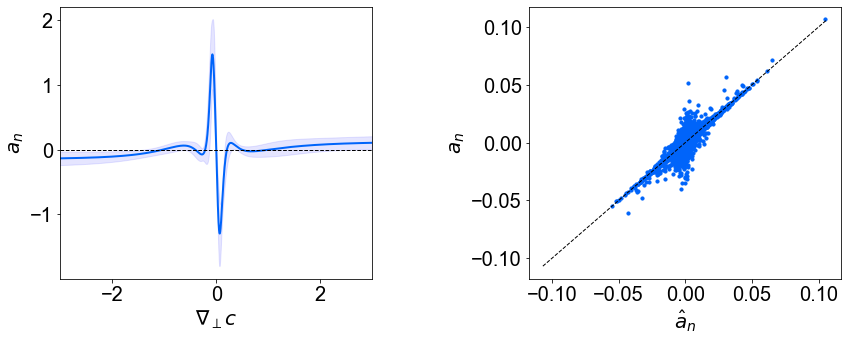

X Intercepts: [-1.016, -0.406, -0.211, 0.002, 0.206, 0.488, 1.025]
Max response: 1.472
Min response: -1.299
Average speed:  0.0182
2nd Local extrema from origin: -0.275 0.281
3rd Local extrema from origin: -0.624 0.677


In [11]:
# --- Post-analysis & Visualization ---
plt.rcParams.update({'font.size': 20, 'font.family': 'Arial'})
color_blue = np.array([0, 100, 250]) / 255


anten_full = np.array(anten_full)
anten_mean = np.nanmean(anten_full, axis=0)
anten_std = np.nanstd(anten_full, axis=0)
plot_x = dc_plot.flatten().cpu().detach().numpy()

# Plot average antennation response
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(plot_x, anten_mean, label='Mean', color=color_blue, linewidth=2)
axs[0].set_xlabel('$\\nabla_\\perp c$')
axs[0].set_ylabel('$a_{n}$')
axs[0].set_xlim(-3, 3)
axs[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axs[0].fill_between(plot_x, anten_mean - anten_std, anten_mean + anten_std, color='blue', alpha=0.1, label='Standard Deviation')

# Scatter plot: predicted vs actual
guide_max = np.max(np.abs(np.concatenate(a_real_full)))
guide_x = np.arange(-guide_max, guide_max, 0.001)
axs[1].scatter(np.concatenate(a_preditced_full), np.concatenate(a_real_full), color=color_blue, s=10)
axs[1].plot(guide_x, guide_x, color='k', linestyle='--', lw=1)
axs[1].set_xlabel('$\hat{a}_{n}$')
axs[1].set_ylabel('$a_{n}$')

plt.subplots_adjust(wspace=0.5)
plt.show()

# --- Analysis of antennation curve characteristics ---

# Find zero crossings (x-intercepts)
zero_crossings = np.where(np.diff(np.signbit(anten_mean)))[0]
x_intercepts = [(plot_x[zc] + plot_x[zc + 1]) / 2 for zc in zero_crossings]
x_intercepts = [round(x, 3) for x in x_intercepts]

# Local extrema
gradient = np.diff(anten_mean)
extrema = np.where(np.diff(np.sign(gradient)))[0]
extrema_x = plot_x[extrema]
extrema_x_positive = extrema_x[extrema_x > 0]
extrema_x_negative = extrema_x[extrema_x < 0]

second_closest_positive = sorted(extrema_x_positive, key=lambda x: abs(x))[1]
second_closest_negative = sorted(extrema_x_negative, key=lambda x: abs(x))[1]
third_closest_positive = sorted(extrema_x_positive, key=lambda x: abs(x))[2]
third_closest_negative = sorted(extrema_x_negative, key=lambda x: abs(x))[2]


print("X Intercepts:", x_intercepts)
print("Max response: %.3f" % np.nanmax(anten_mean))
print("Min response: %.3f" % np.nanmin(anten_mean))
print(f"Average speed: {np.mean(u_mag_mean): .4f}")
print(f"2nd Local extrema from origin: {second_closest_negative:.3f} {second_closest_positive:.3f}")
print(f"3rd Local extrema from origin: {third_closest_negative:.3f} {third_closest_positive:.3f}")

# Calculate the probability of aggregation

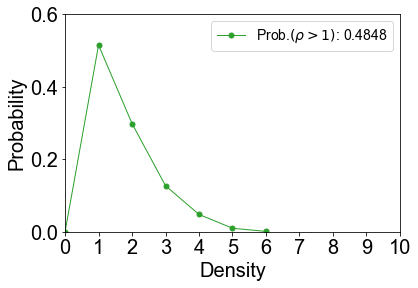

Probability that density > 1: 0.4848


In [12]:
# Compute and store local ant densities within a radius of 0.3m
radius = 0.3           # Radius of local neighborhood (not directly used in this snippet)
density_grain = 0.03   # Radius used to compute local density around each ant

# Initialize list to store densities for each time interval
density_list = []

# Loop through all data intervals
for step in range(len(train_loader)):
    # Get X and Y coordinates for the current interval (shape: [100 timesteps, 16 ants])
    t_known = data_t[100 * step:100 * (step + 1)]
    x_t = data_x[100 * step:100 * (step + 1)].numpy()
    y_t = data_y[100 * step:100 * (step + 1)].numpy()

    # Initialize empty density array for this interval (same shape as x_t)
    density = np.zeros_like(x_t)

    # For each time step
    for t in range(x_t.shape[0]):
        # For each ant at that time
        for agent_idx in range(x_t.shape[1]):
            # Compute pairwise distances from the current ant to all others
            distances = np.sqrt((x_t[t, agent_idx] - x_t[t, :])**2 +
                                (y_t[t, agent_idx] - y_t[t, :])**2)
            # Count how many ants are within the local density radius
            density[t, agent_idx] = np.sum(distances <= density_grain)

    # Flatten and store density for this interval
    density_list.append(density.flatten())

# Convert list of densities to NumPy array (shape: [n_intervals, n_points])
density_array = np.array(density_list)

# Use the selected interval indices (previously identified as meaningful) for analysis
selected_indices = index_full

# Extract and flatten density data from selected intervals
selected_density = density_array[selected_indices, :].flatten()

# Compute PDF (probability density function) of local density
min_density = np.min(selected_density)
max_density = np.max(selected_density)

# Define histogram bin edges and centers
bin_edges = np.arange(-0.5, max_density + 1.5, 1)  # Bin edges for integer density values
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin centers for plotting

# Compute normalized histogram (probability density)
counts, _ = np.histogram(selected_density, bins=bin_edges, density=True)

# Compute probability that local density is greater than 1
mask_gt_1 = bin_centers > 1
probability_gt_1 = np.sum(counts[mask_gt_1])

# Plot the probability density function
plt.figure(figsize=(6, 4))

# Plot PDF as a line with points
plt.plot(bin_centers, counts, 'o-', linewidth=1, markersize=5, color='tab:green',
         label=f'Prob.$(\\rho > 1)$: {probability_gt_1:.4f}')

plt.xlabel('Density')
plt.ylabel('Probability')
plt.xticks(np.arange(0, 16, 1))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xlim(0, 10)
plt.ylim(0, 0.6)

# Show legend (includes probability of density > 1)
plt.legend(loc='upper right', fontsize=14)

# # Save figure as both JPG and EPS formats
# plt.savefig('D:/8. 연구/240129 Collective motions for ants/Final results/graph/' + str(num_colony) + size_ant + '_prob.jpg',
#             bbox_inches='tight', dpi=300)
# plt.savefig('D:/8. 연구/240129 Collective motions for ants/Final results/graph/' + str(num_colony) + size_ant + '_prob.eps',
#             bbox_inches='tight', format='eps')

# Display plot
plt.show()

# Print numerical result
print(f"Probability that density > 1: {probability_gt_1:.4f}")
